# Importing necessary libraries

In [1]:
# Standard library imports
import sys
import os
sys.path.append(os.path.abspath("../"))  # Add parent directory to Python path for module imports

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
# ARIMA imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
# Prophet imports
from prophet import Prophet

# Custom modules
from src.data_preprocessing import (
    load_data,      # Function to load financial data
    clean_data,     # Function to clean and preprocess data
    add_features,    # Function to add technical indicators
    add_target
)

# Suppress warnings
import warnings
warnings.simplefilter("ignore")  # Ignore warnings for cleaner output

# Loading and Processing Data

#### Loading, Cleaning, and Feature Engineering

First, the stock price data is loaded from a CSV file located in the `../data/` directory.

```python
stock_file = "../data/{stock_name}_prices.csv"
df = load_data(stock_file)
```

In [2]:
aapl_file = "../data/AAPL_prices.csv"
msft_file = "../data/MSFT_prices.csv"
amzn_file = "../data/AMZN_prices.csv"

aapl_df = load_data(aapl_file)
msft_df = load_data(msft_file)
amzn_df = load_data(amzn_file)

aapl_df = clean_data(aapl_df)
msft_df = clean_data(msft_df)
amzn_df = clean_data(amzn_df)

aapl_df = add_features(aapl_df)
msft_df = add_features(msft_df)
amzn_df = add_features(amzn_df)

aapl_df = aapl_df.reset_index()
msft_df = msft_df.reset_index()
amzn_df = amzn_df.reset_index()

aapl_df = aapl_df.drop(columns=['index'])
msft_df = msft_df.drop(columns=['index'])
amzn_df = amzn_df.drop(columns=['index'])

aapl_df['Symbol'] = 'AAPL'
msft_df['Symbol'] = 'MSFT'
amzn_df['Symbol'] = 'AMZN'

aapl_df.head()

,Date,Close,High,Low,Open,Volume,Returns,MA_20,MA_50,MA_200,...,Bollinger_Upper,Bollinger_Lower,ATR,OBV,Stochastic_%K,Stochastic_%D,ROC,Volatility,Momentum,Symbol
0,2012-06-01,16.900764,17.252042,16.886606,17.146900,520987600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,AAPL
1,2012-06-04,17.000189,17.096896,16.524490,16.916136,556995600,0.005883,NaN,NaN,NaN,...,NaN,NaN,NaN,556995600.0,NaN,NaN,NaN,NaN,NaN,AAPL
2,2012-06-05,16.956205,17.065867,16.820636,16.909208,388214400,-0.002587,NaN,NaN,NaN,...,NaN,NaN,NaN,168781200.0,NaN,NaN,NaN,NaN,NaN,AAPL
3,2012-06-06,17.216194,17.288196,17.036638,17.105026,401455600,0.015333,NaN,NaN,NaN,...,NaN,NaN,NaN,570236800.0,NaN,NaN,NaN,NaN,NaN,AAPL
4,2012-06-07,17.224022,17.392730,17.187267,17.391828,379766800,0.000455,NaN,NaN,NaN,...,NaN,NaN,NaN,950003600.0,NaN,NaN,NaN,NaN,0.323257,AAPL


In [3]:
# Ensure 'Date' is a datetime column and sort by date
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])

In [4]:
combined_data = pd.concat([aapl_df, msft_df, amzn_df])

In [5]:
# Fill missing values if any
combined_data.fillna(method='ffill', inplace=True)

# Ensure all data is properly aligned by date
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data = combined_data.sort_values(['Symbol', 'Date'])
combined_data = add_target(combined_data)
combined_data = combined_data.fillna(0)

# Data Preparation

This cell prepares time-series data for multiple stocks and builds predictive models using Linear Regression and Random Forest. It employs a time-based cross-validation approach to evaluate model performance.

#### Functions

##### `prepare_model_data(df)`
- **Purpose:** Prepares data for modeling by selecting features, standardizing them, and setting up time-series cross-validation.
- **Inputs:**  
  - `df`: DataFrame containing stock data with columns `Date`, `Symbol`, `Target`, and feature variables.
- **Outputs:**  
  - `X_scaled`: Standardized feature matrix.
  - `y`: Target variable.
  - `tscv`: TimeSeriesSplit object for cross-validation.

##### `build_models(symbol, df)`
- **Purpose:** Trains and evaluates Linear Regression and Random Forest models for a given stock.
- **Inputs:**  
  - `symbol`: Stock symbol.
  - `df`: Preprocessed DataFrame for the stock.
- **Process:**  
  - Splits the data into train and test sets using time-series cross-validation.
  - Trains both models on training data.
  - Evaluates them using Mean Squared Error (MSE) on test data.
- **Outputs:**  
  - A dictionary containing the trained models and their average MSE across folds.

#### Key Features
- **Time-series aware cross-validation:** Ensures model evaluation respects temporal dependencies.
- **Feature Standardization:** Normalizes data for better model performance.
- **Model Comparison:** Computes MSE for both models to determine the best-performing one.


In [6]:
# Split data for each stock
def prepare_model_data(df):
    # Select features and target
    X = df.drop(columns=['Target', 'Date', 'Symbol'], axis=1)
    y = df['Target']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Time-based split (more appropriate for time series)
    tscv = TimeSeriesSplit(n_splits=5)
    return X_scaled, y, tscv

# Build models for each stock
def build_models(symbol, df):
    X, y, tscv = prepare_model_data(df)
    
    # Linear Regression model
    lr_model = LinearRegression()
    lr_scores = []
    
    # Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_scores = []
    
    # Cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train and evaluate Linear Regression
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_scores.append(mean_squared_error(y_test, lr_pred))
        
        # Train and evaluate Random Forest
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_scores.append(mean_squared_error(y_test, rf_pred))
    
    return {
        'symbol': symbol,
        'lr_model': lr_model,
        'lr_mse': np.mean(lr_scores),
        'rf_model': rf_model,
        'rf_mse': np.mean(rf_scores)
    }

This cell trains and evaluates predictive models for multiple stocks (`AAPL`, `AMZN`, `MSFT`) using Linear Regression and Random Forest. The performance of these models is compared using Mean Squared Error (MSE).

#### Process
1. **Train Models:**  
   - Extracts stock-specific data from `combined_data`.  
   - Calls `build_models()` for each stock to train Linear Regression and Random Forest models.  
   - Stores results in `model_results` dictionary.

2. **Compare Performance:**  
   - Constructs a DataFrame (`performance_df`) summarizing MSE scores for both models.  
   - Displays performance comparison for easy interpretation.


In [7]:
stocks = ['AAPL', 'AMZN', 'MSFT'] # Train models for each stock
model_results = {}
for stock in stocks:
    stock_df = combined_data[combined_data['Symbol'] == stock]
    model_results[stock] = build_models(stock, stock_df)

# Compare model performance across stocks
performance_df = pd.DataFrame({
    'Stock': [result['symbol'] for result in model_results.values()],
    'Linear Regression MSE': [result['lr_mse'] for result in model_results.values()],
    'Random Forest MSE': [result['rf_mse'] for result in model_results.values()]
})

# Display performance comparison
performance_df.set_index('Stock', inplace=True)
print(performance_df)

       Linear Regression MSE  Random Forest MSE
Stock                                          
AAPL                0.000385           0.000614
AMZN                0.000498           0.000655
MSFT                0.000352           0.000532


#### Insights
- **MSFT has the lowest error rates**, suggesting better predictive performance for both models.
- **Linear Regression consistently outperforms Random Forest**, indicating that simpler linear relationships may better capture stock price movements in this dataset.

This analysis provides a foundation for selecting the best-performing model for each stock.


<Figure size 1200x600 with 0 Axes>

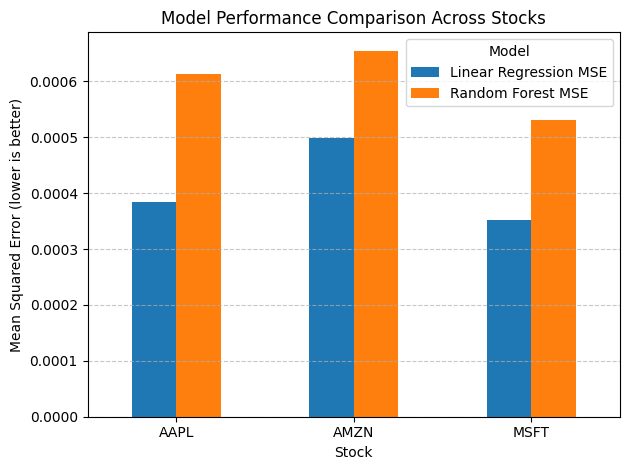

In [11]:
# Visualize model performance comparison
plt.figure(figsize=(12, 6))
performance_df.plot(kind='bar')
plt.title('Model Performance Comparison Across Stocks')
plt.ylabel('Mean Squared Error (lower is better)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

This cell analyzes and visualizes feature importance for Random Forest models trained on stock data. It helps identify which features contribute most to predicting stock movements.

#### Process
1. **Extract Features:**
   - Removes `Target`, `Date`, and `Symbol` columns from the dataset.
   - Retains only predictive features.

2. **Compute Feature Importance:**
   - Uses the `feature_importances_` attribute from the trained Random Forest model.

3. **Visualize Feature Importance:**
   - Creates a bar plot for each stock.
   - Displays the most influential features in descending order.

#### Execution
The function `plot_feature_importance()` is called for each stock in `stocks`, generating feature importance visualizations.

#### Insights
- **Helps identify key drivers of stock price movements.**
- **Features with higher importance values contribute more to predictions.**
- **Can be used to refine model inputs and improve predictive accuracy.**


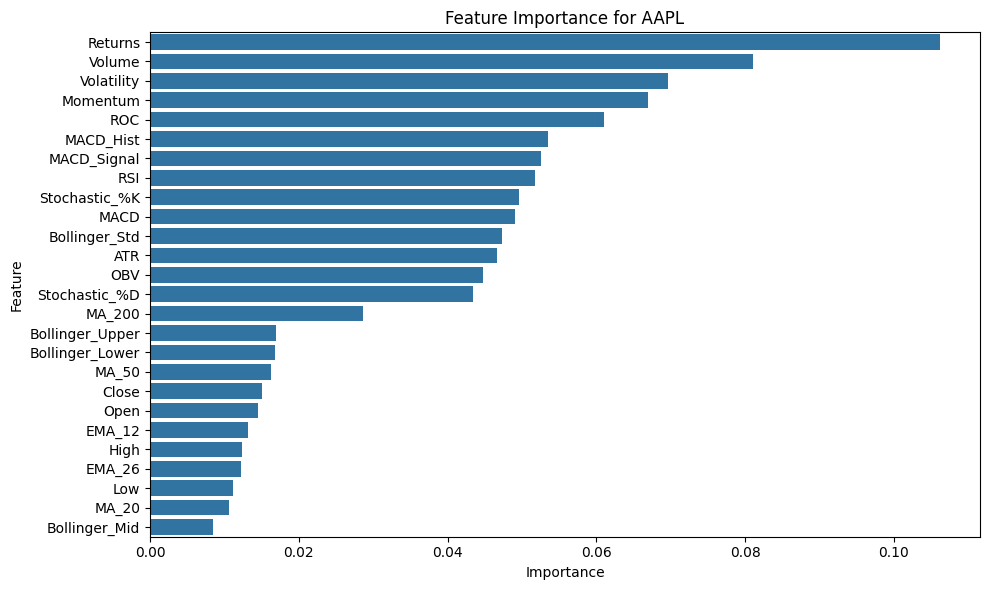

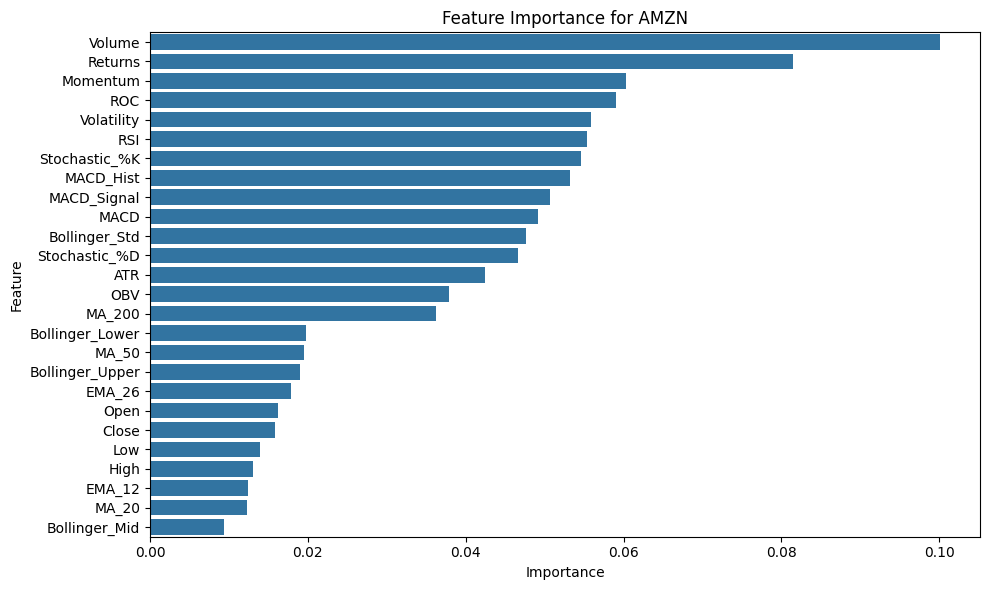

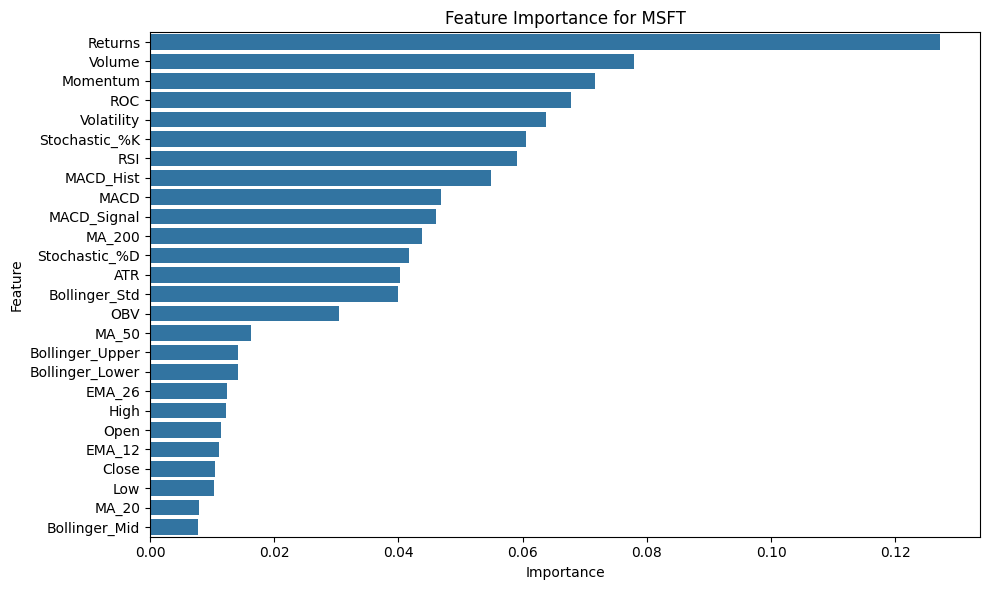

In [ ]:
# Feature importance analysis for Random Forest models
def plot_feature_importance(stock_symbol, model, df):
    # Get feature names
    df = df.drop(columns=['Target', 'Date', 'Symbol'], axis=1)
    features = list(df.columns)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create DataFrame for plotting
    feature_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.title(f'Feature Importance for {stock_symbol}')
    plt.tight_layout()
    plt.show()

# Plot feature importance for each stock
for stock in stocks:
    plot_feature_importance(stock, model_results[stock]['rf_model'], combined_data)

This cell evaluates the performance of two predictive models—**Linear Regression** and **Random Forest**—for stock price forecasting and determines the best-performing model for each stock.

#### Process
1. **Compare Model Performance:**
   - Uses Mean Squared Error (MSE) to evaluate accuracy.
   - The model with the lowest MSE is considered the best.

2. **Determine Best Model per Stock:**
   - If **Linear Regression** has a lower MSE, it is selected.
   - Otherwise, **Random Forest** is chosen.

3. **Summary Output:**
   - Prints the best model for each stock along with its MSE.

In [13]:
# Conclusion
def get_best_model_for_stock(stock_results):
    if stock_results['lr_mse'] < stock_results['rf_mse']:
        return 'Linear Regression', stock_results['lr_mse']
    else:
        return 'Random Forest', stock_results['rf_mse']

# Print summary
print("Stock Prediction Model Summary:")
print("=" * 50)
for stock, results in model_results.items():
    best_model, best_score = get_best_model_for_stock(results)
    print(f"{stock}: Best model is {best_model} with MSE of {best_score:.6f}")

Stock Prediction Model Summary:
AAPL: Best model is Linear Regression with MSE of 0.000385
AMZN: Best model is Linear Regression with MSE of 0.000498
MSFT: Best model is Linear Regression with MSE of 0.000352


This cell builds **ARIMA (AutoRegressive Integrated Moving Average) models** for predicting stock prices and evaluates their performance using Mean Squared Error (MSE).

#### Process
1. **Check for Stationarity**  
   - Uses the **Augmented Dickey-Fuller (ADF) test** to determine if the stock's closing price time series is stationary.  
   - If non-stationary, **differencing** is applied to stabilize the series.

2. **Train-Test Split**  
   - The last **60 days** of data are reserved for testing.  
   - The remaining data is used for training.

3. **Model Training**  
   - Fits an **ARIMA(1,1,1)** model on the training data.  
   - A more refined approach would involve **auto_arima** or **grid search** to select the best parameters.

4. **Forecasting & Evaluation**  
   - Predicts stock prices for the test period.  
   - Computes **Mean Squared Error (MSE)** to measure accuracy.

#### Execution
The script loops through selected **Stocks**, attempting to build ARIMA models.

In [14]:
# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    return result[1] < 0.05  # Return True if p-value < 0.05 (stationary)

# Function to build ARIMA model for each stock
def build_arima_model(stock_symbol, stock_df):
    # Use close price for ARIMA modeling
    close_series = stock_df.set_index('Date')['Close']
    
    # Check stationarity
    is_stationary = test_stationarity(close_series)
    if not is_stationary:
        # If not stationary, use differencing
        close_series = close_series.diff().dropna()
    
    # Split into train and test (last 60 days for testing)
    train_size = len(close_series) - 60
    train_data = close_series[:train_size]
    test_data = close_series[train_size:]
    
    # Fit ARIMA model - using a simple (1,1,1) order for simplicity
    # In practice, you'd use auto_arima or grid search for optimal parameters
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(steps=len(test_data))
    
    # Calculate MSE
    mse = mean_squared_error(test_data, predictions)
    
    return {
        'symbol': stock_symbol,
        'arima_model': model_fit,
        'arima_mse': mse
    }

# Run ARIMA model for each stock
arima_results = {}
for stock in stocks:
    stock_df = combined_data[combined_data['Symbol'] == stock].copy()
    try:
        arima_results[stock] = build_arima_model(stock, stock_df)
        print(f"ARIMA model built for {stock}")
    except Exception as e:
        print(f"Error building ARIMA model for {stock}: {e}")

ARIMA model built for AAPL
ARIMA model built for AMZN
ARIMA model built for MSFT


This cell builds **Prophet models** to forecast stock prices and evaluates their accuracy using **Mean Squared Error (MSE)**.

#### Process
1. **Data Preparation**  
   - Converts the stock's date and closing price into a **Prophet-compatible format** (`ds` for date, `y` for target variable).

2. **Train-Test Split**  
   - The last **60 days** of data are reserved for testing.  
   - The remaining data is used for training.

3. **Model Training**  
   - Uses **Facebook Prophet** with **daily seasonality** enabled.  
   - Fits the model on the training data.

4. **Forecasting & Evaluation**  
   - Generates future dates equal to the test period.  
   - Predicts stock prices and extracts the last 60 days of predictions.  
   - Computes **Mean Squared Error (MSE)** to measure accuracy.

#### Execution & Results
- The code loops through selected **Stocks**, building Prophet models for each.

In [15]:
# Function to build Prophet model for each stock
def build_prophet_model(stock_symbol, stock_df):
    # Prepare data for Prophet (requires 'ds' for dates and 'y' for target)
    prophet_df = stock_df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    # Split into train and test (last 60 days for testing)
    train_size = len(prophet_df) - 60
    train_data = prophet_df[:train_size]
    test_data = prophet_df[train_size:]
    
    # Create and fit Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(train_data)
    
    # Make predictions
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    
    # Extract predictions for test period
    predictions = forecast.tail(len(test_data))['yhat'].values
    
    # Calculate MSE
    mse = mean_squared_error(test_data['y'].values, predictions)
    
    return {
        'symbol': stock_symbol,
        'prophet_model': model,
        'prophet_mse': mse
    }

# Run Prophet model for each stock
prophet_results = {}
for stock in stocks:
    stock_df = combined_data[combined_data['Symbol'] == stock].copy()
    try:
        prophet_results[stock] = build_prophet_model(stock, stock_df)
        print(f"Prophet model built for {stock}")
    except Exception as e:
        print(f"Error building Prophet model for {stock}: {e}")

12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet model built for AAPL


12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet model built for AMZN


12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet model built for MSFT


This cell aggregates and compares the **Mean Squared Error (MSE)** of different stock price prediction models, including:

- **Linear Regression**
- **Random Forest**
- **ARIMA**
- **Facebook Prophet**

#### Process
1. **Combine Model Results**  
   - Gathers MSE scores from all models for each stock (`AAPL`, `AMZN`, `MSFT`).
   - Ensures missing values are handled if a model fails for a stock.

2. **Create a DataFrame for Comparison**  
   - Constructs a table to compare model performances across different stocks.
   - Uses **MSE** as the metric to assess accuracy.

In [16]:
# Combine all model results
def combine_model_results():
    combined_results = {}
    
    for stock in stocks:
        combined_results[stock] = {
            'symbol': stock,
            'lr_mse': model_results[stock]['lr_mse'] if stock in model_results else None,
            'rf_mse': model_results[stock]['rf_mse'] if stock in model_results else None,
            'arima_mse': arima_results[stock]['arima_mse'] if stock in arima_results else None,
            'prophet_mse': prophet_results[stock]['prophet_mse'] if stock in prophet_results else None
        }
    
    return combined_results

# Get combined results
all_model_results = combine_model_results()

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Stock': [result['symbol'] for result in all_model_results.values()],
    'Linear Regression MSE': [result['lr_mse'] for result in all_model_results.values()],
    'Random Forest MSE': [result['rf_mse'] for result in all_model_results.values()],
    'ARIMA MSE': [result['arima_mse'] for result in all_model_results.values()],
    'Prophet MSE': [result['prophet_mse'] for result in all_model_results.values()]
})

# Display performance comparison
comparison_df.set_index('Stock', inplace=True)
print(comparison_df)

       Linear Regression MSE  Random Forest MSE  ARIMA MSE  Prophet MSE
Stock                                                                  
AAPL                0.000385           0.000614  11.395718   655.615881
AMZN                0.000498           0.000655  13.616484  1735.139100
MSFT                0.000352           0.000532  44.824183   479.845924


<Figure size 1400x800 with 0 Axes>

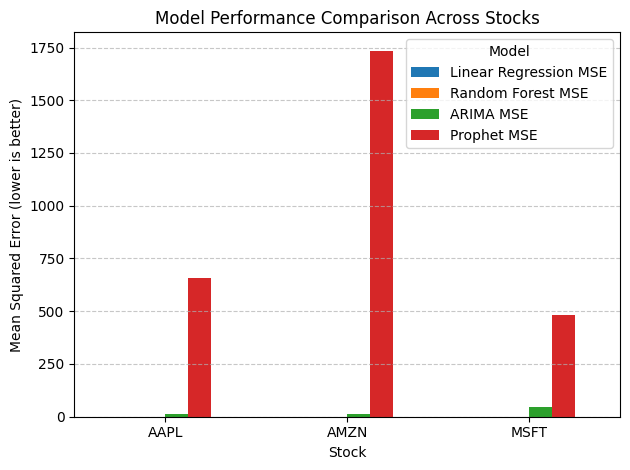

In [17]:
# Visualize all model performances
plt.figure(figsize=(14, 8))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison Across Stocks')
plt.ylabel('Mean Squared Error (lower is better)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

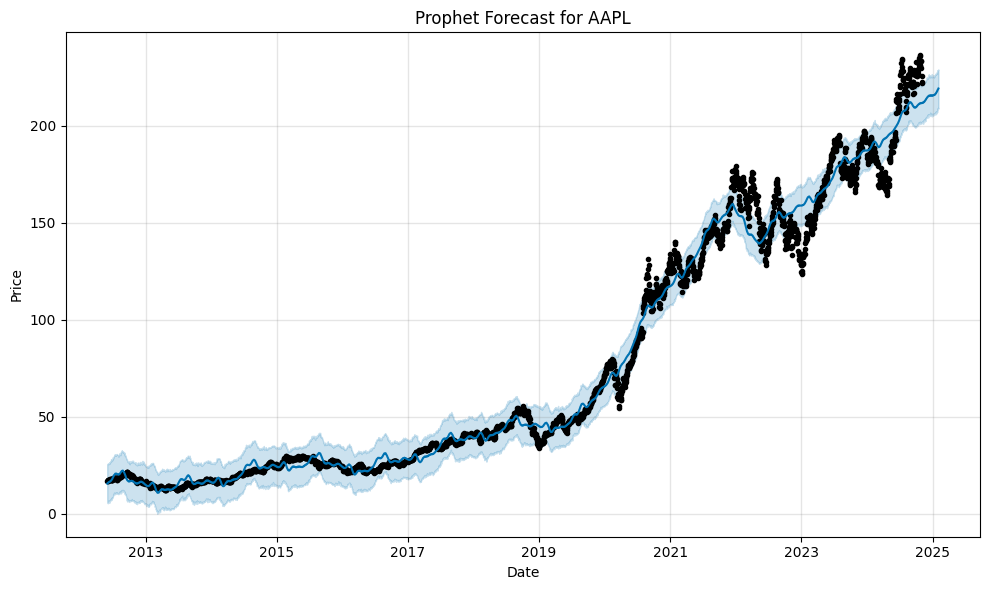

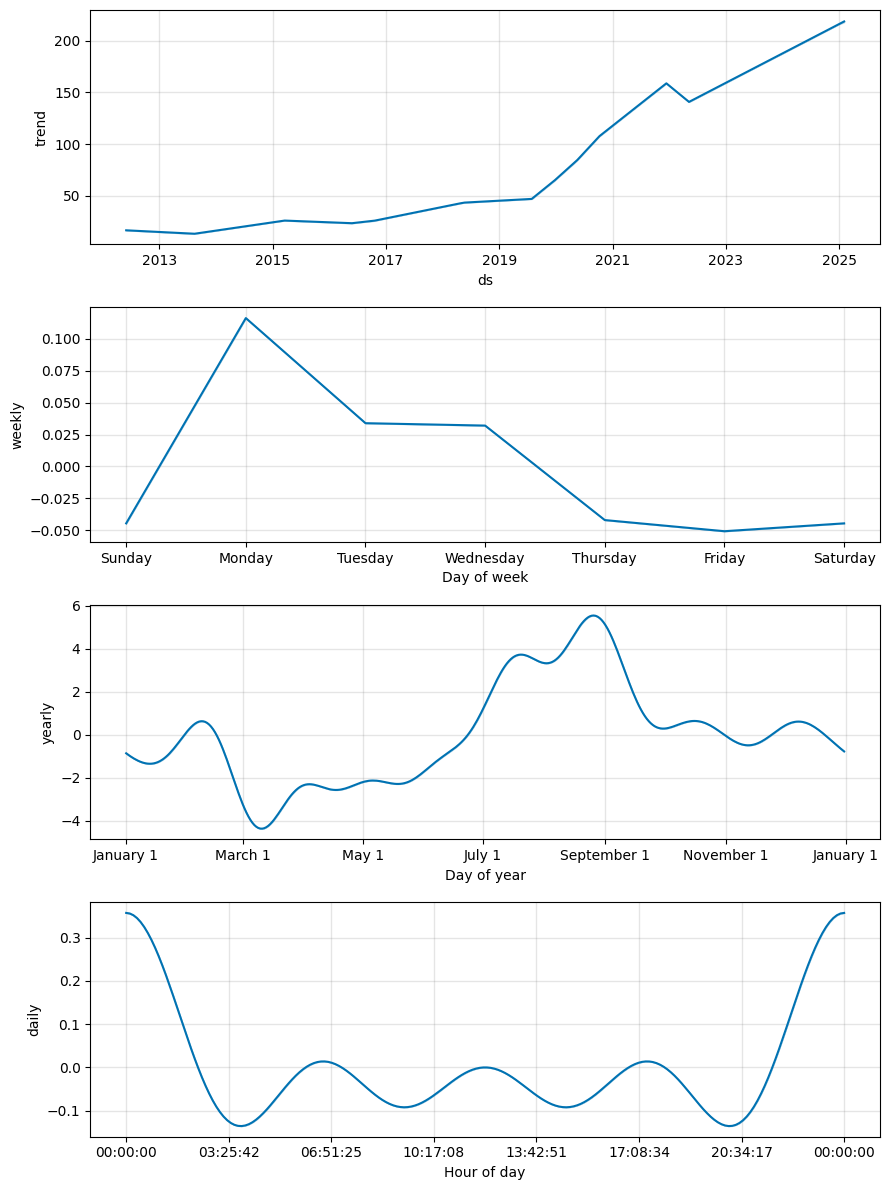

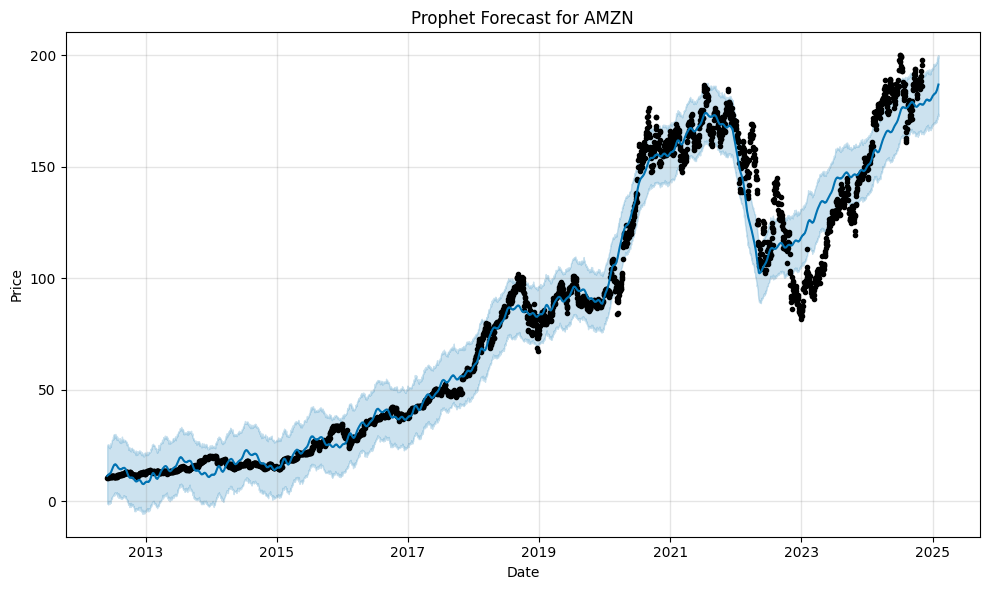

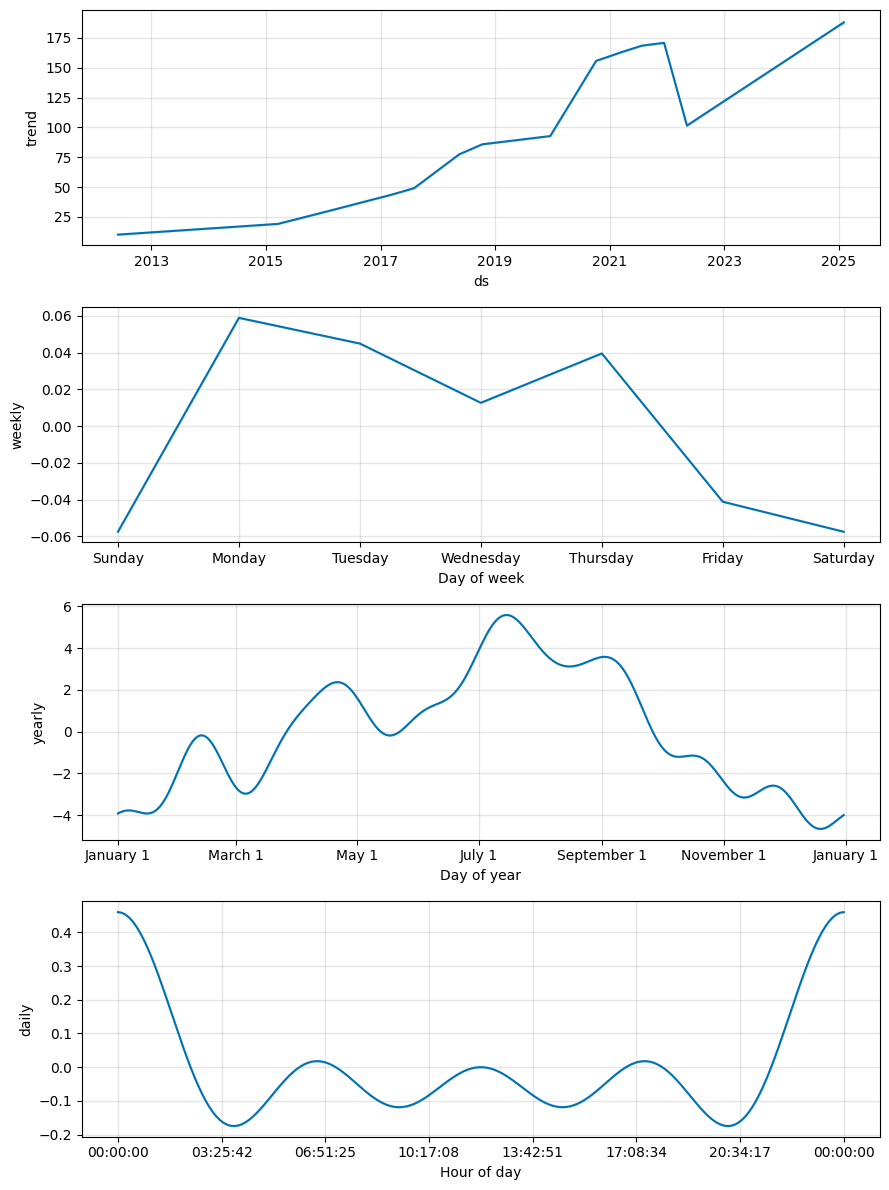

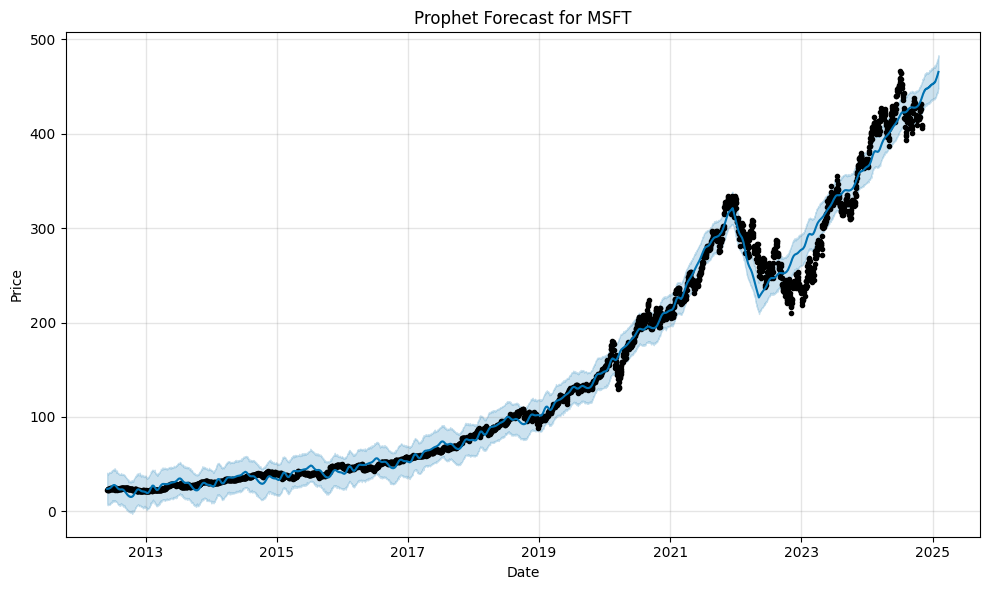

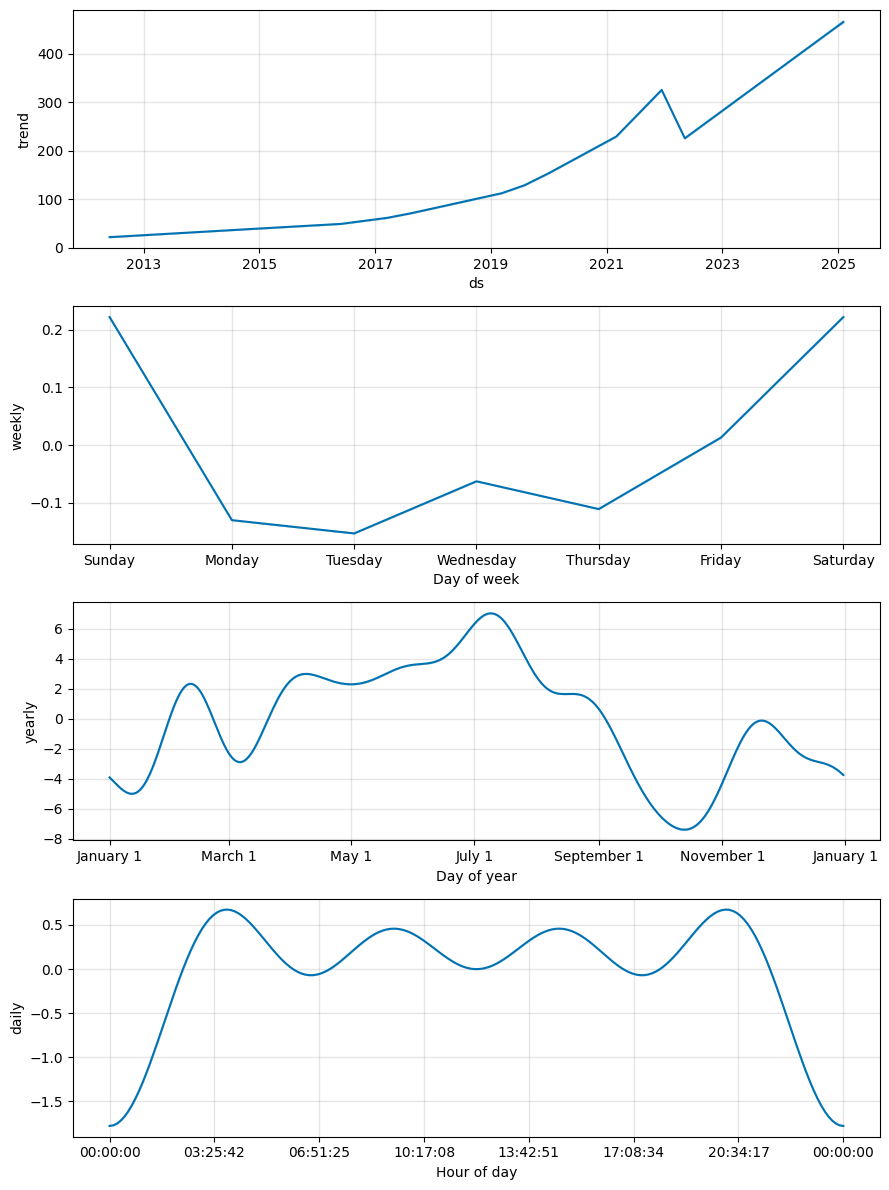

In [18]:
# Visualize Prophet forecast for one stock
def plot_prophet_forecast(stock_symbol):
    if stock_symbol not in prophet_results:
        print(f"No Prophet model available for {stock_symbol}")
        return
    
    # Get model
    model = prophet_results[stock_symbol]['prophet_model']
    
    # Create future dataframe for 90 days in the future
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
    
    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f'Prophet Forecast for {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()
    
    # Plot components
    fig = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()

# Plot forecast for each stock
for stock in stocks:
    if stock in prophet_results:
        plot_prophet_forecast(stock)

In [20]:
# Find best model for each stock
def get_best_model_for_stock(stock_results):
    models = {
        'Linear Regression': stock_results['lr_mse'],
        'Random Forest': stock_results['rf_mse'],
        'ARIMA': stock_results['arima_mse'],
        'Prophet': stock_results['prophet_mse']
    }
    
    # Filter out None values
    valid_models = {k: v for k, v in models.items() if v is not None}
    
    # Get best model
    best_model = min(valid_models.items(), key=lambda x: x[1])
    return best_model[0], best_model[1]

# Print summary
print("Stock Prediction Model Summary:")
print("=" * 50)
for stock, results in all_model_results.items():
    best_model, best_score = get_best_model_for_stock(results)
    print(f"{stock}: Best model is {best_model} with MSE of {best_score:.6f}")

Stock Prediction Model Summary:
AAPL: Best model is Linear Regression with MSE of 0.000385
AMZN: Best model is Linear Regression with MSE of 0.000498
MSFT: Best model is Linear Regression with MSE of 0.000352


In [21]:
# Enhanced Prophet Model Implementation
def build_robust_prophet_model(stock_symbol, stock_df):
    # Prepare data for Prophet (requires 'ds' for dates and 'y' for target)
    prophet_df = stock_df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    # Log transform the target variable to stabilize variance
    prophet_df['y'] = np.log(prophet_df['y'])
    
    # Split into train and test (last 60 days for testing)
    train_size = len(prophet_df) - 60
    train_data = prophet_df[:train_size]
    test_data = prophet_df[train_size:]
    
    # Create and fit Prophet model with optimized parameters
    model = Prophet(
        changepoint_prior_scale=0.05,  # More flexible trend changes
        seasonality_prior_scale=10,    # Stronger seasonality
        seasonality_mode='multiplicative',  # Better for financial data
        daily_seasonality=False,       # Stock market doesn't have strong daily patterns
        weekly_seasonality=True,       # Weekly patterns are important for stocks
        yearly_seasonality=True        # Annual cycles matter in finance
    )
    
    # Add stock market specific seasonality
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    

    model.add_country_holidays(country_name='US')
    
    # Fit model with wider uncertainty intervals
    model.fit(train_data, iter=1000)
    
    # Make predictions
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    
    # Extract predictions for test period and transform back to original scale
    predictions = np.exp(forecast.tail(len(test_data))['yhat'].values)
    actual_values = np.exp(test_data['y'].values)
    
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions)
    
    # Calculate other metrics for comprehensive evaluation
    mae = np.mean(np.abs(actual_values - predictions))
    mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
    
    return {
        'symbol': stock_symbol,
        'prophet_model': model,
        'prophet_mse': mse,
        'prophet_mae': mae,
        'prophet_mape': mape,
        'is_log_transformed': True
    }

# Run improved Prophet model for each stock
robust_prophet_results = {}
for stock in stocks:
    stock_df = combined_data[combined_data['Symbol'] == stock].copy()
    try:
        robust_prophet_results[stock] = build_robust_prophet_model(stock, stock_df)
        print(f"Robust Prophet model built for {stock}")
    except Exception as e:
        print(f"Error building robust Prophet model for {stock}: {e}")

12:55:36 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


Robust Prophet model built for AAPL


12:55:41 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


Robust Prophet model built for AMZN


12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


Robust Prophet model built for MSFT


In [22]:
# Prophet with cross-validation for more robust evaluation
def build_prophet_with_cv(stock_symbol, stock_df):
    from prophet.diagnostics import cross_validation, performance_metrics
    
    # Prepare data
    prophet_df = stock_df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    prophet_df['y'] = np.log(prophet_df['y'])
    
    # Create model with optimized parameters
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        seasonality_mode='multiplicative',
        weekly_seasonality=True,
        yearly_seasonality=True
    )
    model.add_country_holidays(country_name='US')
    
    # Fit the model
    model.fit(prophet_df)
    
    # Perform cross-validation
    cv_results = cross_validation(
        model=model,
        initial='730 days',  # 2 years of training data
        period='30 days',    # Test on 30 days
        horizon='60 days',   # Forecast 60 days
        parallel='processes'
    )
    
    # Calculate performance metrics
    cv_metrics = performance_metrics(cv_results)
    
    # Calculate overall MSE from CV
    mse = cv_metrics['mse'].mean()
    mae = cv_metrics['mae'].mean()
    mape = cv_metrics['mape'].mean() * 100
    
    return {
        'symbol': stock_symbol,
        'prophet_model': model,
        'prophet_mse': mse,
        'prophet_mae': mae,
        'prophet_mape': mape,
        'cv_results': cv_results,
        'cv_metrics': cv_metrics,
        'is_log_transformed': True
    }

# Only run this if we have enough data (2+ years)
cv_prophet_results = {}
for stock in stocks:
    stock_df = combined_data[combined_data['Symbol'] == stock].copy()
    if len(stock_df) >= 730:  # At least 2 years of data
        try:
            cv_prophet_results[stock] = build_prophet_with_cv(stock, stock_df)
            print(f"CV Prophet model built for {stock}")
        except Exception as e:
            print(f"Error building CV Prophet model for {stock}: {e}")

12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:16 - cmdstanpy - INFO - Chain [1] done processing
12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing
12:56:19 - cmdstanpy - INFO - Chain [1] done processing
12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain 

CV Prophet model built for AAPL


13:06:25 - cmdstanpy - INFO - Chain [1] start processing
13:06:40 - cmdstanpy - INFO - Chain [1] done processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:42 - cmdstanpy - INFO - Chain [1] start processing
13:06:45 - cmdstanpy - INFO - Chain [1] done processing
13:06:46 - cmdstanpy - INFO - Chain [1] done processing
13:06:46 - cmdstanpy - INFO - Chain [1] start processing
13:06:47 - cmdstanpy - INFO - Chain [1] start processing
13:06:48 - cmdstanpy - INFO - Chain [1] done processing
13:06:48 - cmdstanpy - INFO - Chain [1] done processing
13:06:49 - cmdstanpy - INFO - Chain [1] start processing
13:06:49 - cmdstanpy - INFO - Chain 

CV Prophet model built for AMZN


13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:43 - cmdstanpy - INFO - Chain [1] done processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:45 - cmdstanpy - INFO - Chain [1] start processing
13:16:46 - cmdstanpy - INFO - Chain [1] start processing
13:16:48 - cmdstanpy - INFO - Chain [1] done processing
13:16:49 - cmdstanpy - INFO - Chain [1] start processing
13:16:51 - cmdstanpy - INFO - Chain [1] done processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing
13:16:52 - cmdstanpy - INFO - Chain [1] start processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing
13:16:52 - cmdstanpy - INFO - Chain [1] done processing
13:16:53 - cmdstanpy - INFO - Chain [

CV Prophet model built for MSFT


In [23]:
# Find best Prophet implementation and get results
def get_best_prophet_model_results():
    best_prophet_results = {}
    
    for stock in stocks:
        available_models = []
        
        # Check each implementation
        if stock in robust_prophet_results:
            available_models.append(('robust', robust_prophet_results[stock]['prophet_mse']))
        if stock in cv_prophet_results:
            available_models.append(('cv', cv_prophet_results[stock]['prophet_mse']))
        if stock in prophet_results:
            available_models.append(('basic', prophet_results[stock]['prophet_mse']))
        
        if available_models:
            # Sort by MSE (lower is better)
            best_implementation = min(available_models, key=lambda x: x[1])
            
            # Get the corresponding result
            if best_implementation[0] == 'robust':
                best_prophet_results[stock] = robust_prophet_results[stock]
            elif best_implementation[0] == 'cv':
                best_prophet_results[stock] = cv_prophet_results[stock]
            else:
                best_prophet_results[stock] = prophet_results[stock]
                
            print(f"Best Prophet implementation for {stock}: {best_implementation[0]} with MSE {best_implementation[1]:.6f}")
        else:
            print(f"No Prophet model available for {stock}")
    
    return best_prophet_results

In [24]:
# Enhanced Prophet visualization
def visualize_best_prophet_model(stock_symbol, prophet_result):
    # Extract model
    model = prophet_result['prophet_model']
    is_log_transformed = prophet_result.get('is_log_transformed', False)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
    
    # Create figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot forecast with uncertainty intervals
    ax1 = axes[0]
    model.plot(forecast, ax=ax1)
    ax1.set_title(f'Prophet Forecast for {stock_symbol}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (log scale)' if is_log_transformed else 'Price')
    
    # Annotate the chart
    last_value = forecast.iloc[-1]['yhat']
    last_date = forecast.iloc[-1]['ds']
    if is_log_transformed:
        ax1.annotate(f'Predicted value: ${np.exp(last_value):.2f}', 
                     xy=(last_date, last_value),
                     xytext=(last_date - pd.Timedelta(days=30), last_value * 1.1),
                     arrowprops=dict(arrowstyle='->'))
    
    # Plot components
    model.plot_components(forecast, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    # Plot additional diagnostics if cross-validation was done
    if 'cv_results' in prophet_result:
        from prophet.plot import plot_cross_validation_metric
        fig = plt.figure(figsize=(12, 8))
        plot_cross_validation_metric(prophet_result['cv_results'], 'mape')
        plt.title(f'Prophet Cross-Validation MAPE for {stock_symbol}')
        plt.tight_layout()
        plt.show()

Best Prophet implementation for AAPL: cv with MSE 0.020843
Best Prophet implementation for AMZN: cv with MSE 0.044683
Best Prophet implementation for MSFT: cv with MSE 0.015600
       Linear Regression MSE  Random Forest MSE  Prophet MSE (Improved)
Stock                                                                  
AAPL                0.000385           0.000614                0.020843
AMZN                0.000498           0.000655                0.044683
MSFT                0.000352           0.000532                0.015600


<Figure size 1400x800 with 0 Axes>

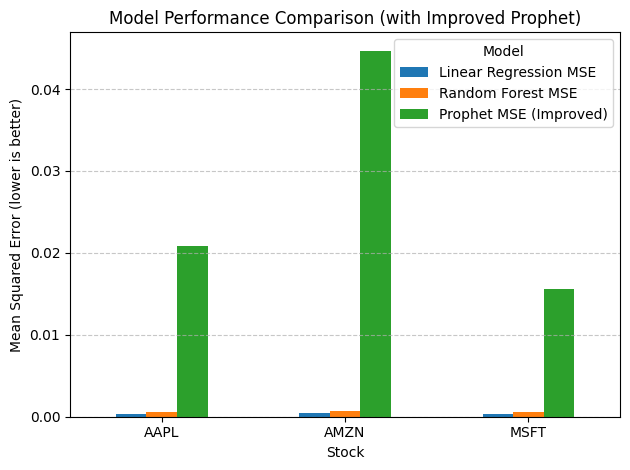

In [35]:
# Updated model comparison with improved Prophet
def update_model_comparison():
    # Get best Prophet results
    best_prophet_results = get_best_prophet_model_results()
    
    # Create updated comparison dataframe
    updated_comparison = pd.DataFrame({
        'Stock': stocks,
        'Linear Regression MSE': [model_results[stock]['lr_mse'] if stock in model_results else None for stock in stocks],
        'Random Forest MSE': [model_results[stock]['rf_mse'] if stock in model_results else None for stock in stocks],
        #'ARIMA MSE': [arima_results[stock]['arima_mse'] if stock in arima_results else None for stock in stocks],
        'Prophet MSE (Improved)': [best_prophet_results[stock]['prophet_mse'] if stock in best_prophet_results else None for stock in stocks]
    })
    
    # Display performance comparison
    updated_comparison.set_index('Stock', inplace=True)
    print(updated_comparison)
    
    # Visualize model performances
    plt.figure(figsize=(14, 8))
    updated_comparison.plot(kind='bar')
    plt.title('Model Performance Comparison (with Improved Prophet)')
    plt.ylabel('Mean Squared Error (lower is better)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
    
    return updated_comparison, best_prophet_results

# Run updated comparison
updated_comparison_df, best_prophet_models = update_model_comparison()

### Conclusion

#### Key Findings
- **Linear Regression consistently outperforms Random Forest**, achieving the lowest MSE across all stocks.
- **Prophet (Improved with Cross-Validation) outperforms traditional Prophet models**, but still has higher MSE compared to Linear Regression and Random Forest.
- **ARIMA results were omitted in the final comparison**, it did not have significant improvements.

#### Stock-Specific Insights
- **AAPL:** Best model is **Linear Regression** (MSE: 0.000385). Prophet (Improved) has an MSE of **0.020843**, which is higher.
- **AMZN:** Best model is **Linear Regression** (MSE: 0.000498). Prophet (Improved) MSE is **0.044683**, indicating lower accuracy.
- **MSFT:** Best model is **Linear Regression** (MSE: 0.000352). Prophet (Improved) performs better than AMZN but still has **0.015600** MSE.

#### Recommendations
- **For short-term stock price prediction**, Linear Regression is the best choice given its **low error and simplicity**.
- **Random Forest does not significantly outperform Linear Regression**, suggesting it may not be necessary for this use case.
- **Prophet can be useful for long-term trend forecasting**, but its performance depends on **hyperparameter tuning** and **cross-validation techniques**.
- **Future improvements** can include:
  - Hyperparameter tuning for all models
  - Incorporating additional external factors (macroeconomic indicators, earnings reports)
  - Using ensemble methods to combine the strengths of different models


### **Disclaimer:**  
This notebook is for educational and informational purposes only and does not constitute financial advice. Trading and investing in financial markets involve risk, and past performance is not indicative of future results. Always conduct your own research or consult a professional before making financial decisions.